In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from src.anchor_generator import tile_anchors

In [3]:
WIDTH, HEIGHT = 512, 1024
GRID_WIDTH, GRID_HEIGHT = 16, 32  # stride 32 or scale 0 in the face detector
# GRID_WIDTH, GRID_HEIGHT = 8, 16  # stride 64 or scale 1 in the face detector
# GRID_WIDTH, GRID_HEIGHT = 4, 8  # stride 128 or scale 2 in the face detector

# Generate anchors

In [4]:
tf.reset_default_graph()

n = 4
anchors = tile_anchors(
    (WIDTH, HEIGHT), GRID_HEIGHT, GRID_WIDTH,
    scale=32, aspect_ratio=1.0, 
    anchor_stride=(1.0/GRID_HEIGHT, 1.0/GRID_WIDTH), 
    anchor_offset=(0.5/GRID_HEIGHT, 0.5/GRID_WIDTH), 
    n=n
)

In [5]:
with tf.Session() as sess:
    anchor_boxes = sess.run(anchors)

scaler = np.array([HEIGHT, WIDTH, HEIGHT, WIDTH], dtype='float32')
anchor_boxes = anchor_boxes*scaler  # shape [GRID_HEIGHT, GRID_WIDTH, n*n, 4]

# Show some non clipped anchors

In [6]:
def get_grid_centers():
    anchor_stride = (1.0/GRID_HEIGHT, 1.0/GRID_WIDTH)
    anchor_offset = (0.5/GRID_HEIGHT, 0.5/GRID_WIDTH)

    y_center = np.arange(GRID_HEIGHT, dtype='float32') * anchor_stride[0] + anchor_offset[0]
    x_center = np.arange(GRID_WIDTH, dtype='float32') * anchor_stride[1] + anchor_offset[1]
    x_center, y_center = np.meshgrid(x_center, y_center)
    # they have shape [grid_height, grid_width]

    centers = np.stack([y_center, x_center], axis=2)
    scaler = np.array([HEIGHT, WIDTH], dtype='float32')
    centers = centers*scaler
    return centers


def plot(anchor_boxes, cell_to_show):
    fig, ax = plt.subplots(1, dpi=120, figsize=(int(8*WIDTH/HEIGHT), 8))

    grid_centers = get_grid_centers()
    for point in grid_centers.reshape(-1, 2):
        cy, cx = point
        ax.plot([cx], [cy], marker='.', markersize=1, color='r')
    
    iy, ix = cell_to_show
    cy, cx = grid_centers[iy, ix, :]
    ax.plot([cx], [cy], marker='.', markersize=5, color='r')
    
    cy, cx, h, w = [anchor_boxes[:, :, :, i] for i in range(4)]
    centers = np.stack([cy, cx], axis=3)
    anchor_sizes = np.stack([h, w], axis=3)

    centers = centers[iy, ix, :, :]
    anchor_sizes = anchor_sizes[iy, ix, :, :]
    
    to_show = [1, 4, 15]
    for i, center, box in zip(range(len(centers)), centers, anchor_sizes):
        
        h, w = box
        cy, cx = center
        xmin, ymin = cx - 0.5*w, cy - 0.5*h

        linestyle = '-' if i in to_show else '--' 
        random_color = np.random.rand(3,)
        color = random_color if i in to_show else 'k'
        alpha = 1.0 if i in to_show else 0.5
        linewidth = 2.0 if i in to_show else 0.7

        rect = plt.Rectangle(
            (xmin, ymin), w, h,
            linewidth=linewidth, edgecolor=color, 
            facecolor='none', linestyle=linestyle,
            alpha=alpha
        )
        if i in to_show:
            ax.plot([cx], [cy], marker='s', markersize=7, color=random_color)
        ax.add_patch(rect)
    
    # why not ax.axis('equal')?
    ax.set_ylim([0, HEIGHT])
    ax.set_xlim([0, WIDTH])
    ax.invert_yaxis()

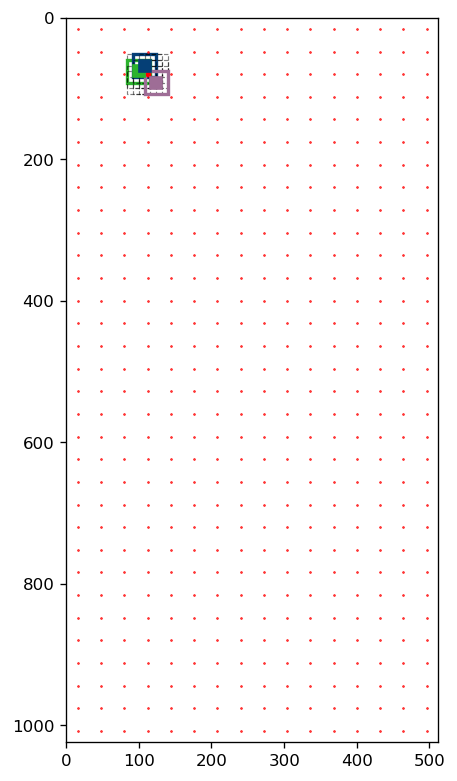

In [7]:
plot(anchor_boxes, cell_to_show=(2, 3))